In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import pyplot
from datetime import datetime

# ML
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = [17, 6]
plt.rcParams.update({'font.size': 12})

# France Energy Production Forecasting - ML models (Assignment 2)

In [3]:
adf = pd.read_csv('Datasets/all_data.csv', header=None)

In [4]:
adf.drop([33,34,35], axis=1, inplace=True)

In [5]:
adf.shape

(31181, 33)

In [6]:
datelist = pd.date_range(datetime(2017,1,1,0), periods=adf.shape[0],freq='H').tolist()
adf['datetime'] = datelist
adf.set_index('datetime', drop=True, inplace=True)

# Other Models

### Helper functions

In [7]:
def plot_preds(y_test, y_pred_test):
    plt.scatter(y_test,y_pred_test)
    rng = [y_test.min(), y_test.max()]
    plt.plot(rng, rng,'r')
    plt.show()
    
def plot_lags(y_test, y_pred_test, lag=50):
    s1 = pd.Series(y_test.reshape(-1))
    s2 = pd.Series(y_pred_test.reshape(-1))
    
    rng = range(lag)
    s = pd.Series([s2.corr(s1.shift(i)) for i in rng], index=rng)
    print('Max Lag Correlation : {:4f} (Lag = {:d})'.format(s.max(), s.idxmax())) 
    plt.plot(s)

In [8]:
# def evaluate(y_test, y_pred):
#     mse = mean_squared_error(y_test, y_pred)
#     print()

##### Pre-Processing

In [9]:
def normalise(series):
    return (series - series.mean())/series.std()

In [10]:
data_df = adf.copy()[[0] + list(range(1,9)) + list(range(17,25))][[0, 22,24,21]]

# data_df['year'] = data_df.index.year
data_df['month'] = data_df.index.month
data_df['hour'] = data_df.index.hour

data_df['month_sin'] = data_df.month.apply(lambda m: math.sin((m-1)/12 * 2 * math.pi))
data_df['month_cos'] = data_df.month.apply(lambda m: math.cos((m-1)/12 * 2 * math.pi))
data_df['hr_sin'] = data_df.hour.apply(lambda h: math.sin(h/24 * 2 * math.pi))
data_df['hr_cos'] = data_df.hour.apply(lambda h: math.cos(h/24 * 2 * math.pi))

data_df['0_normalised'] = normalise(data_df[0])
data_df['22_normalised'] = normalise(data_df[22])
data_df['24_normalised'] = normalise(data_df[24])
data_df['21_normalised'] = normalise(data_df[21])

data_df.head()

,0,22,24,21,month,hour,month_sin,month_cos,hr_sin,hr_cos,0_normalised,22_normalised,24_normalised,21_normalised
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,2.73,2.74,2.52,1,0,0.0,1.0,0.000000,1.000000,-0.917884,-0.624888,-0.637534,-0.715575
2017-01-01 01:00:00,0.0,2.72,2.72,2.52,1,1,0.0,1.0,0.258819,0.965926,-0.917884,-0.629738,-0.647194,-0.715575
2017-01-01 02:00:00,0.0,2.72,2.70,2.51,1,2,0.0,1.0,0.500000,0.866025,-0.917884,-0.629738,-0.656854,-0.720556
2017-01-01 03:00:00,0.0,2.71,2.68,2.51,1,3,0.0,1.0,0.707107,0.707107,-0.917884,-0.634588,-0.666513,-0.720556
2017-01-01 04:00:00,0.0,2.70,2.66,2.51,1,4,0.0,1.0,0.866025,0.500000,-0.917884,-0.639438,-0.676173,-0.720556


In [11]:
# Convert for standard model/network

WINDOW_ENERGY = 20
WINDOW_WIND = range(-2,3)

list_of_energy_dfs = [data_df[['0_normalised']].shift(i).rename({'0_normalised':'0shift' + str(i)}, axis=1) 
                         for i in range(18,18 + WINDOW_ENERGY)]
list_of_energy_dfs_mean = data_df[['0_normalised']].shift(18).rename({'0_normalised':'0shift_mean'}, axis=1
                                                                    ).rolling(WINDOW_ENERGY).mean()
list_of_wind_dfs = [data_df[['22_normalised','24_normalised','21_normalised']].shift(i) for i in WINDOW_WIND]
dates_df = data_df[['month_sin', 'month_cos', 'hr_sin', 'hr_cos']].shift(18)

data = pd.concat(list_of_energy_dfs + [list_of_energy_dfs_mean, dates_df] +
                 list_of_wind_dfs + [data_df['0_normalised']], axis =1).dropna().reset_index(drop=True)

# data = data[['0_normalised']]
print('# Columns : ', data.shape[1])
data.tail()

# Columns :  41


,0shift18,0shift19,0shift20,0shift21,0shift22,0shift23,0shift24,0shift25,0shift26,0shift27,...,22_normalised,24_normalised,21_normalised,22_normalised,24_normalised,21_normalised,22_normalised,24_normalised,21_normalised,0_normalised
31137,0.964682,1.200003,1.539911,1.945185,1.853672,2.010552,1.579131,1.552984,0.873168,0.245646,...,-0.576387,-0.647194,-0.441628,-0.542436,-0.608555,-0.416723,-0.508485,-0.569916,-0.396800,0.245646
31138,0.284867,0.964682,1.200003,1.539911,1.945185,1.853672,2.010552,1.579131,1.552984,0.873168,...,-0.615188,-0.681003,-0.461551,-0.576387,-0.647194,-0.441628,-0.542436,-0.608555,-0.416723,0.036472
31139,-0.146555,0.284867,0.964682,1.200003,1.539911,1.945185,1.853672,2.010552,1.579131,1.552984,...,-0.649139,-0.719642,-0.481475,-0.615188,-0.681003,-0.461551,-0.576387,-0.647194,-0.441628,0.219500
31140,-0.381876,-0.146555,0.284867,0.964682,1.200003,1.539911,1.945185,1.853672,2.010552,1.579131,...,-0.683090,-0.758281,-0.501398,-0.649139,-0.719642,-0.481475,-0.615188,-0.681003,-0.461551,0.324087
31141,-0.564903,-0.381876,-0.146555,0.284867,0.964682,1.200003,1.539911,1.945185,1.853672,2.010552,...,-0.717041,-0.796920,-0.521322,-0.683090,-0.758281,-0.501398,-0.649139,-0.719642,-0.481475,0.311013


In [12]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

In [13]:
# Convert for difference model/network

WINDOW_ENERGY = 20
WINDOW_WIND = range(-2,3)

wind_diff_df = data_df[['22_normalised','24_normalised','21_normalised']].diff(18)
list_of_wind_dfs = [wind_diff_df.shift(i) for i in WINDOW_WIND]

diff_df = data_df[['0_normalised']].diff(18)
list_of_dfs = [diff_df[['0_normalised']].shift(i) for i in range(18,18 + WINDOW_ENERGY)]

min_df = diff_df[['0_normalised']].shift(18).rolling(window=WINDOW_ENERGY).min()
max_df = diff_df[['0_normalised']].shift(18).rolling(window=WINDOW_ENERGY).max()
mean_df = diff_df[['0_normalised']].shift(18).rolling(window=WINDOW_ENERGY).mean()

dates_df = data_df[['month_sin', 'month_cos', 'hr_sin', 'hr_cos']].shift(18)

data_diff = pd.concat(list_of_dfs + [min_df, max_df, mean_df, dates_df] + list_of_wind_dfs + [diff_df, data_df[['0_normalised']].shift(18)]
                 , axis=1).dropna().reset_index(drop=True)

print('# Columns : ', data_diff.shape[1])
data_diff.tail()

# Columns :  44


,0_normalised,0_normalised,0_normalised,0_normalised,0_normalised,0_normalised,0_normalised,0_normalised,0_normalised,0_normalised,...,24_normalised,21_normalised,22_normalised,24_normalised,21_normalised,22_normalised,24_normalised,21_normalised,0_normalised,0_normalised
31119,1.137384,1.189677,1.699539,2.130960,1.856419,1.738759,0.836696,0.575229,0.013073,-0.836696,...,-0.671354,-0.373565,-0.635367,-0.671354,-0.368584,-0.635367,-0.671354,-0.368584,-0.719036,0.964682
31120,0.522935,1.137384,1.189677,1.699539,2.130960,1.856419,1.738759,0.836696,0.575229,0.013073,...,-0.666525,-0.368584,-0.635367,-0.671354,-0.373565,-0.635367,-0.671354,-0.368584,-0.248394,0.284867
31121,0.091514,0.522935,1.137384,1.189677,1.699539,2.130960,1.856419,1.738759,0.836696,0.575229,...,-0.671354,-0.368584,-0.640217,-0.666525,-0.368584,-0.635367,-0.671354,-0.373565,0.366055,-0.146555
31122,-0.222247,0.091514,0.522935,1.137384,1.189677,1.699539,2.130960,1.856419,1.738759,0.836696,...,-0.671354,-0.368584,-0.635367,-0.671354,-0.368584,-0.640217,-0.666525,-0.368584,0.705962,-0.381876
31123,-0.274541,-0.222247,0.091514,0.522935,1.137384,1.189677,1.699539,2.130960,1.856419,1.738759,...,-0.671354,-0.368584,-0.635367,-0.671354,-0.368584,-0.635367,-0.671354,-0.368584,0.875916,-0.564903


In [14]:
# Change from X,y to A,b
A = data_diff.iloc[:, :-2].values
b = data_diff.iloc[:, -2:].values # 18 hr differences
# b0 = data_df[['0_normalised']].shift(18).values # so actual prediction will be b + b0

A_train, A_test, b_train, b_test = train_test_split(A, b, shuffle=False, test_size=0.3)

b0_train = b_train[:,1:].copy()
b0_test = b_test[:,1:].copy()
b_train = b_train[:,:1].copy()
b_test = b_test[:,:1].copy()

##### Plotting

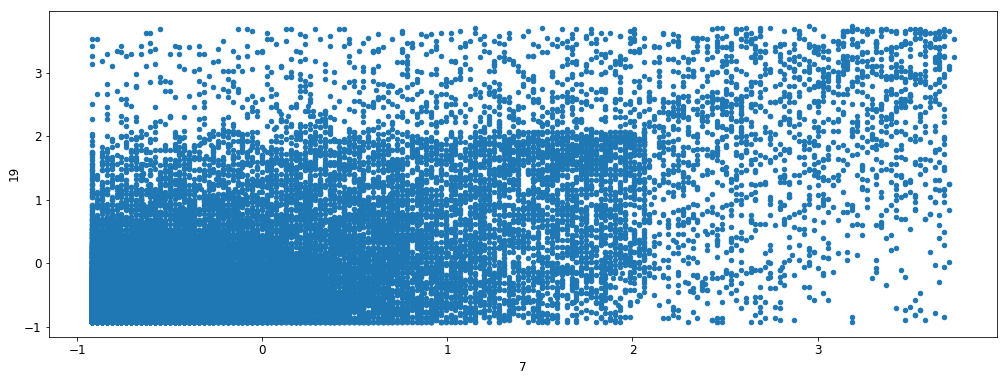

In [15]:
xdf = data.copy()
k = len(xdf.columns)
xdf.columns = range(k)
xdf.plot(x=7, y=19,kind='scatter')

### Persistence (T+18)

In [16]:
# Persistence for Raw/unnormalised data
predictions = data_df[0].shift(18)
# note this is MSE not RMSE, same as euclidean loss
mean_squared_error(data_df[0][~predictions.isna()], predictions[~predictions.isna()])

325932987.23646635

MSE on dataset :  0.8912996642701421


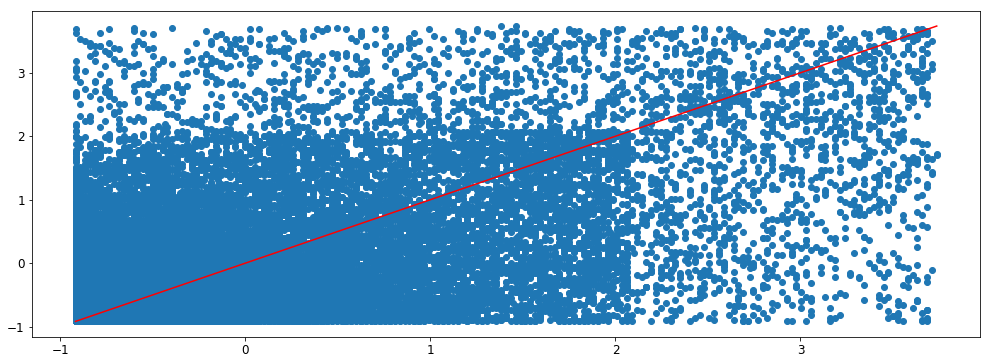

Max Lag Correlation : 1.000000 (Lag = 18)


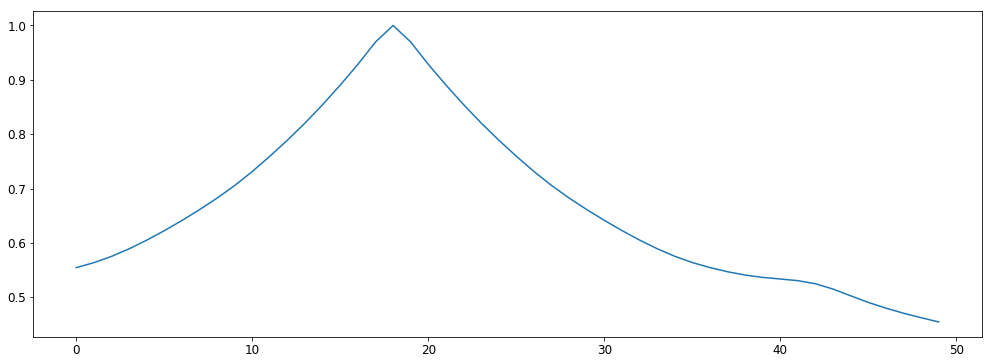

In [17]:
# Must use data from normal model
LAG = 18
y_persistence_pred = data_df['0_normalised'].shift(LAG)[LAG:].values
y_persistence_test = data_df['0_normalised'][LAG:].values

# Note Autocaffee does MSE/2
mse = mean_squared_error(y_persistence_test, y_persistence_pred)
print('MSE on dataset : ', mse)

plot_preds(y_persistence_test,y_persistence_pred)
plot_lags(y_persistence_test,y_persistence_pred)

### Multiple Linear Regression

MSE on train dataset :  0.1194950758487186
MSE on test dataset :  0.8700657679246945


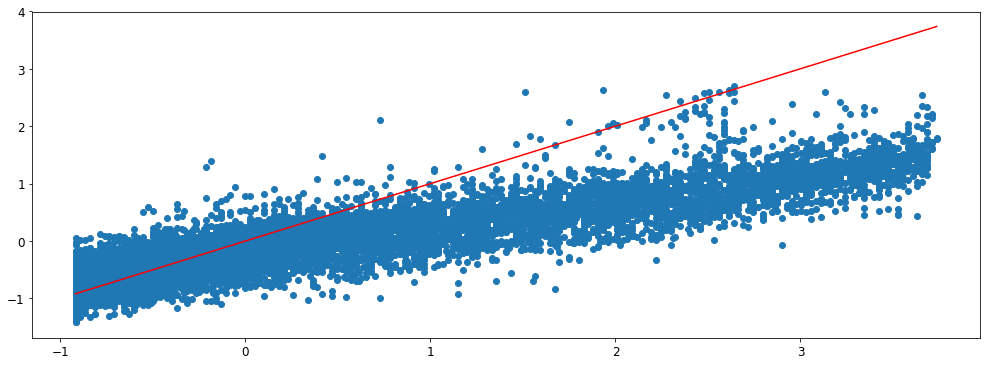

Max Lag Correlation : 0.885590 (Lag = 0)


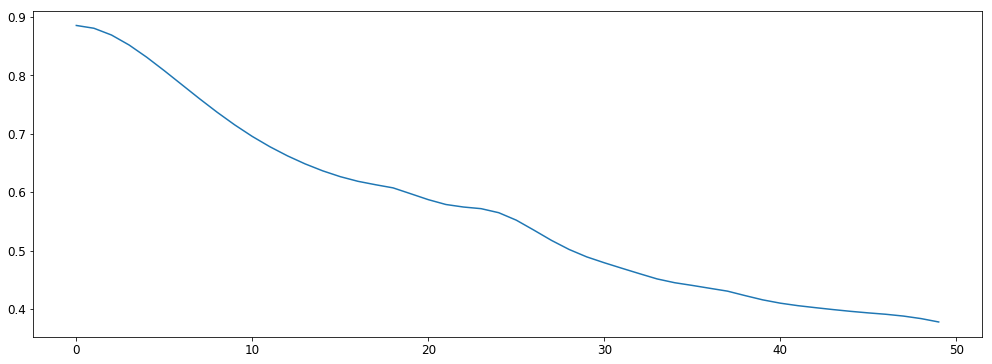

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

# plot_preds(y_train,y_pred_train)

# print('Coefficient of model :', model.coef_)
# print('Intercept of model',model.intercept_)

# For 1D predictors
# plt.scatter(X_test, y_test)
# plt.plot(X_test, y_pred, color='red') # regression line

- This is clearly over fitted from the train and test losses
- another observation is that from the graph, a polynomial graph might do better (think fitting linear reg to x^2)

MSE on train dataset :  0.17241450451935805
MSE on test dataset :  0.707707836995208


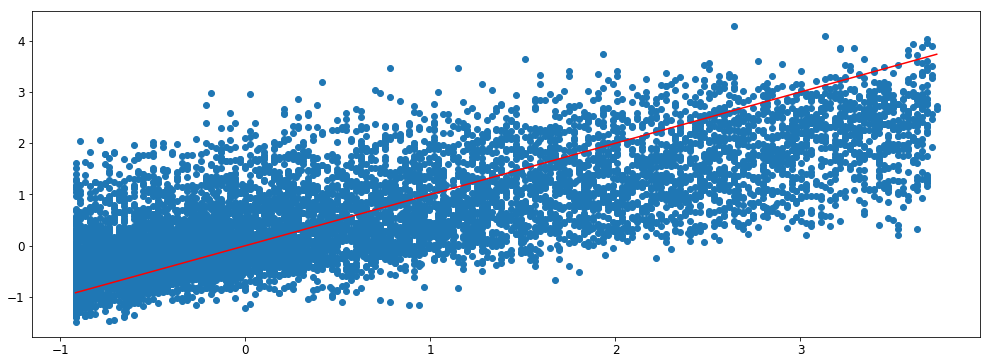

Max Lag Correlation : 0.841393 (Lag = 18)


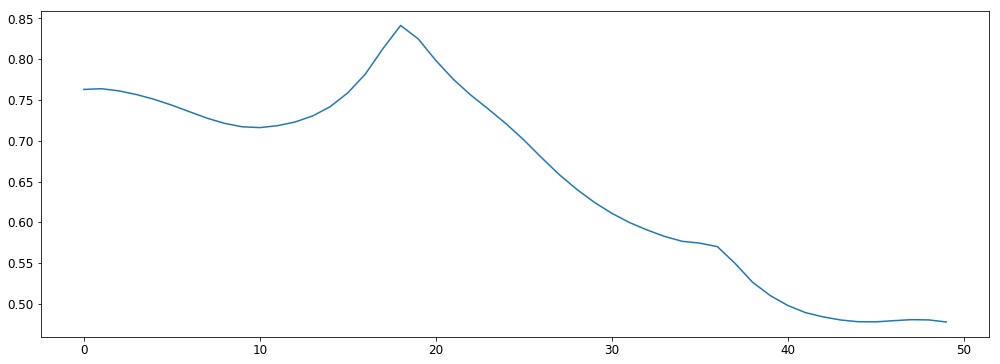

In [19]:
model = LinearRegression()
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train)
b_pred_test = model.predict(A_test)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### Multiple Polynomial  Regression

- very sensitive to outliers

# Features :  861
MSE on train dataset :  0.10534674811547894
MSE on test dataset :  0.8669977552327205


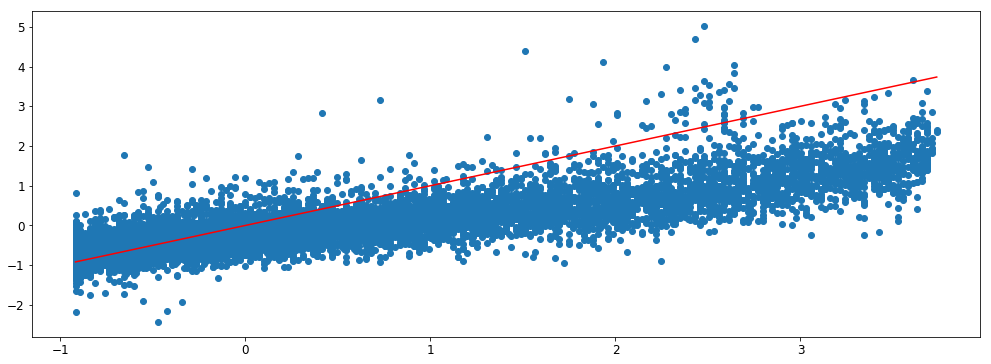

Max Lag Correlation : 0.839542 (Lag = 0)


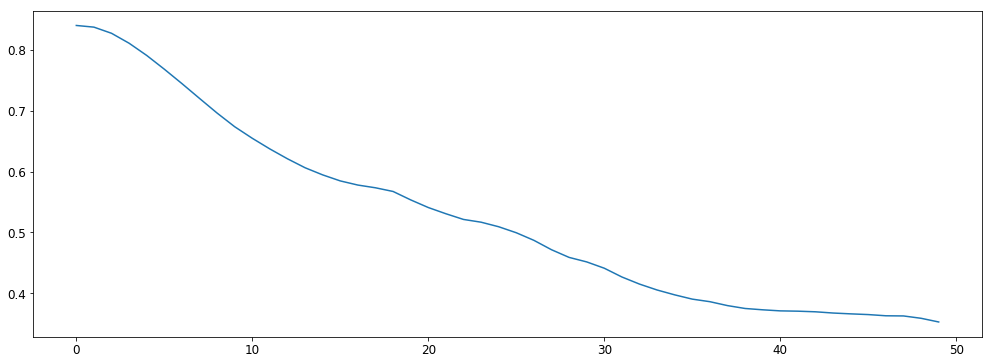

In [20]:
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 2) 
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
print('# Features : ', X_train_poly.shape[1])

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred_train = model.predict(X_train_poly)
y_pred_test = model.predict(X_test_poly)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

- polynomial reg is able to explain abit of the higher energy levels
- surprisingly not much better

# Features :  946
MSE on train dataset :  0.14682490505011256
MSE on test dataset :  0.6755600104450643


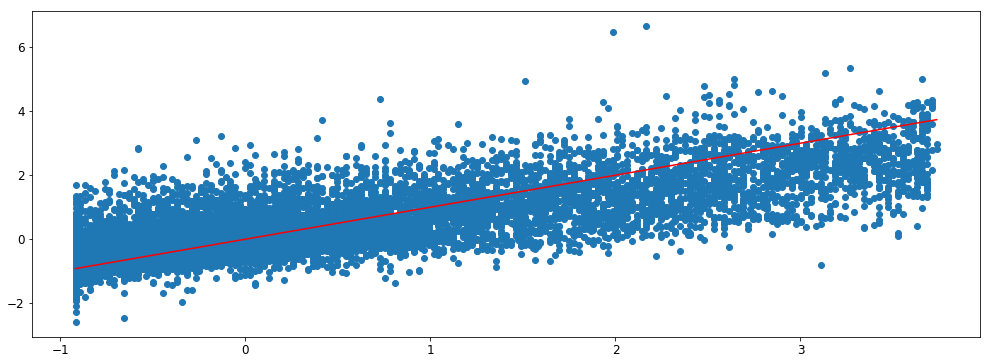

Max Lag Correlation : 0.779044 (Lag = 0)


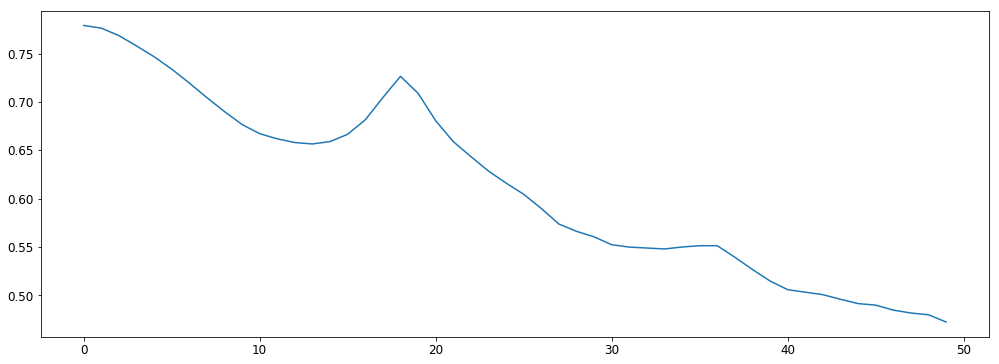

In [21]:
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 2) 
A_train_poly = poly.fit_transform(A_train)
A_test_poly = poly.fit_transform(A_test)
print('# Features : ', A_train_poly.shape[1])

model = LinearRegression()
model.fit(A_train_poly, b_train)

b_pred_train = model.predict(A_train_poly)
b_pred_test = model.predict(A_test_poly)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### Decision Trees

- can also be used for regression problems (usu for classification)

MSE on train dataset :  9.60476167820326e-33
MSE on test dataset :  1.0181748321098516


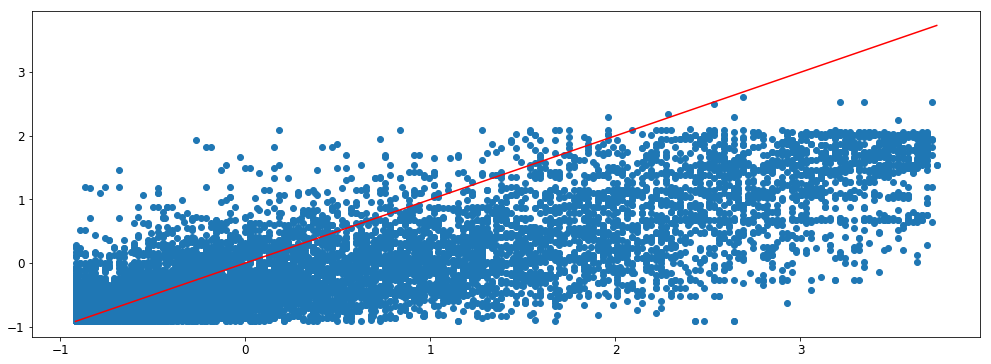

Max Lag Correlation : 0.796354 (Lag = 0)


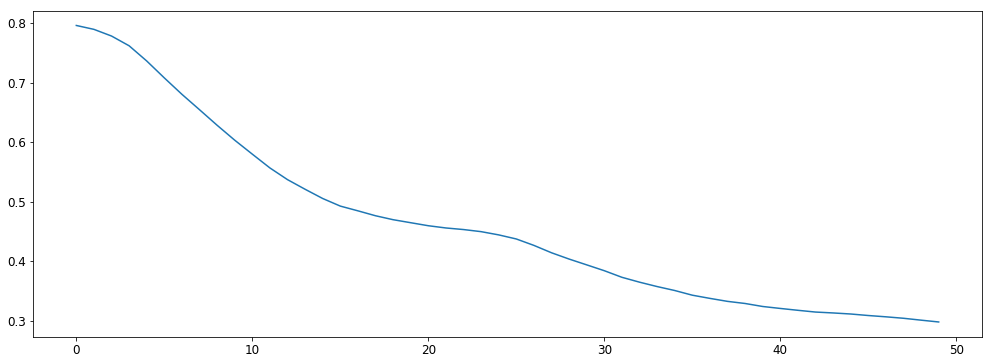

In [22]:
from sklearn.tree import DecisionTreeRegressor 

model = DecisionTreeRegressor(random_state = 0) 
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

MSE on train dataset :  8.899878656473971e-34
MSE on test dataset :  0.9562823018207367


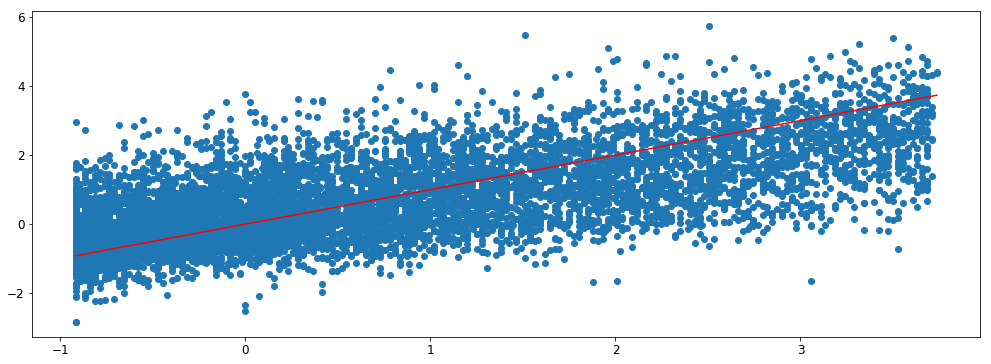

Max Lag Correlation : 0.741535 (Lag = 18)


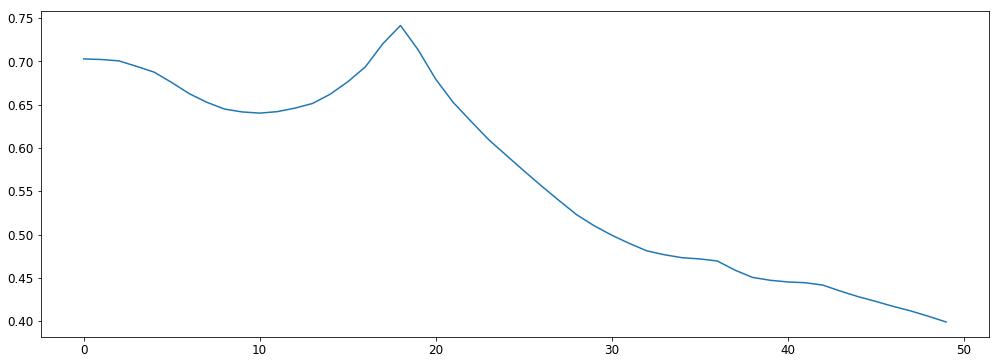

In [23]:
model = DecisionTreeRegressor(random_state = 0) 
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### Random Forest

- to combat high variance of decision trees

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


MSE on train dataset :  0.009676911507558311
MSE on test dataset :  0.8644198989390707


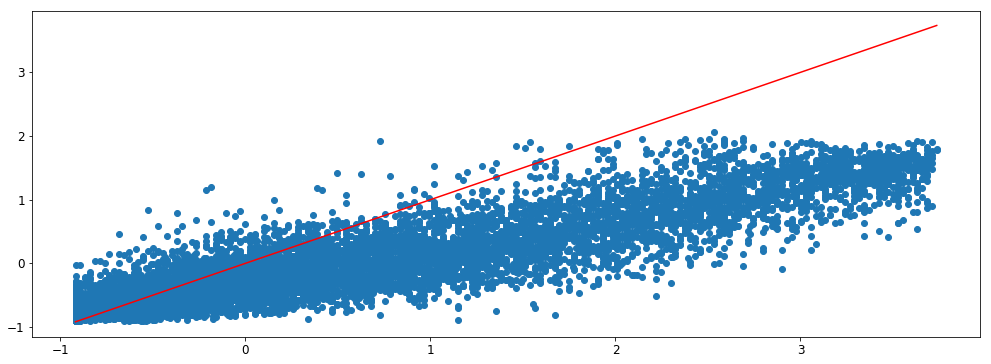

Max Lag Correlation : 0.902244 (Lag = 0)


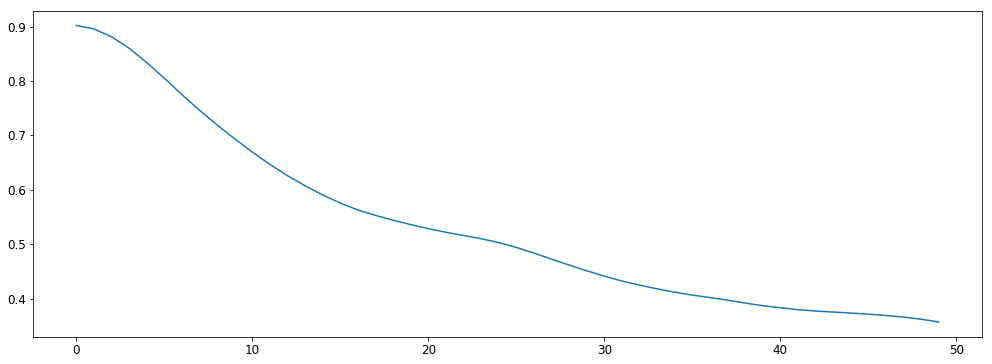

In [24]:
from sklearn.ensemble import RandomForestRegressor 
  
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE on train dataset :  0.016988470344085908
MSE on test dataset :  0.6824494611833505


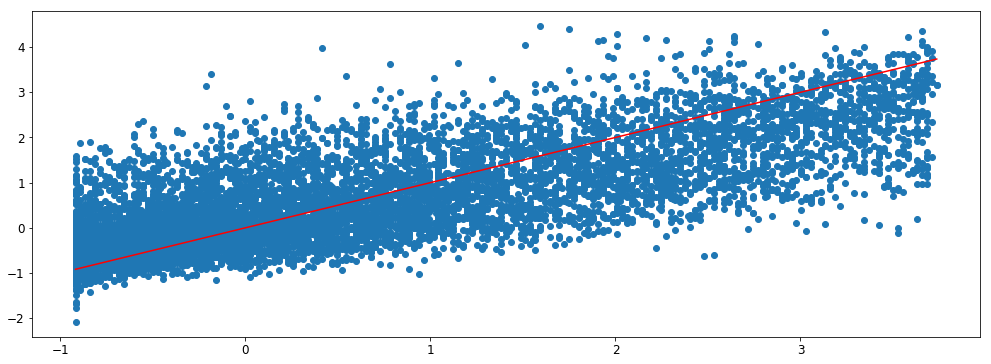

Max Lag Correlation : 0.829280 (Lag = 18)


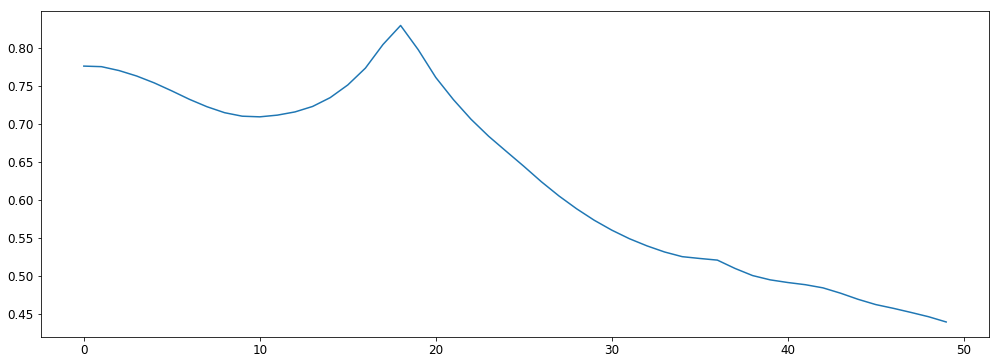

In [25]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test, c_pred_test)
plot_lags(c_test, c_pred_test)

### SVR

- same concept as SVM (classification version which is the more common use case)
- choice of kernal is important

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on train dataset :  0.08368239863813803
MSE on test dataset :  0.9370752250380514


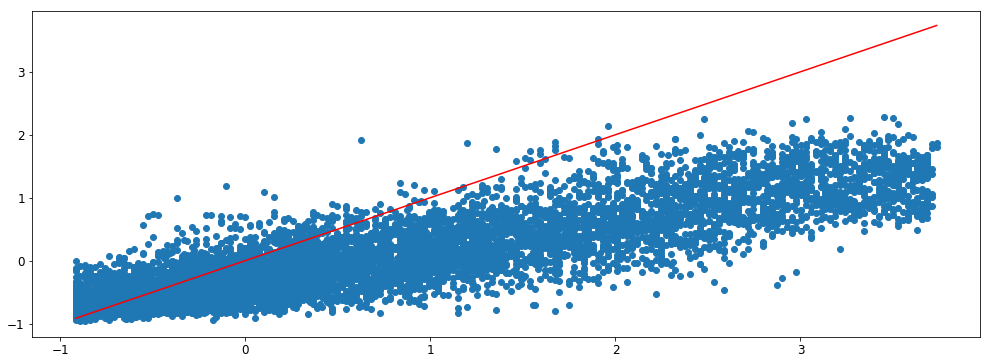

Max Lag Correlation : 0.884217 (Lag = 0)


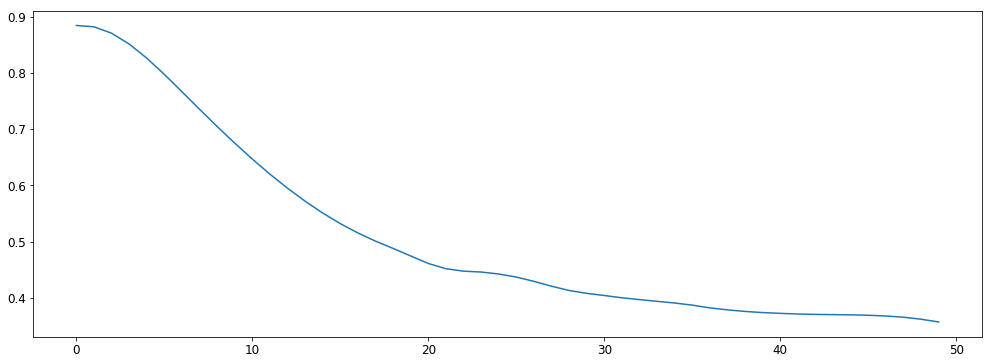

In [26]:
from sklearn.svm import SVR

model = SVR(kernel = 'rbf')
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on train dataset :  0.1188955557014832
MSE on test dataset :  0.7234826474254569


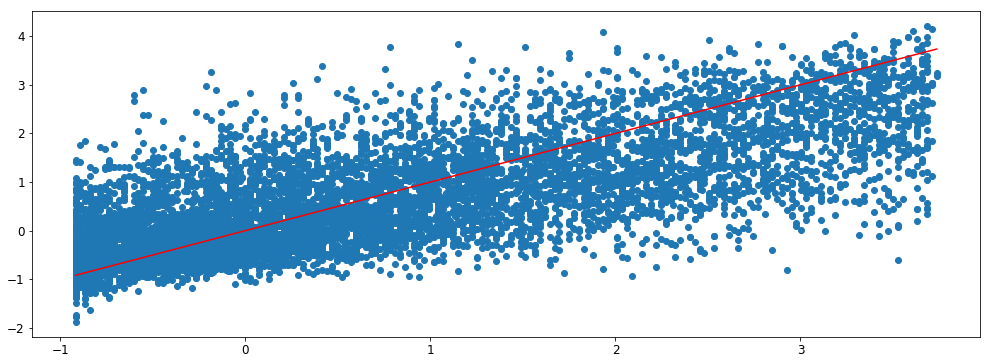

Max Lag Correlation : 0.825000 (Lag = 18)


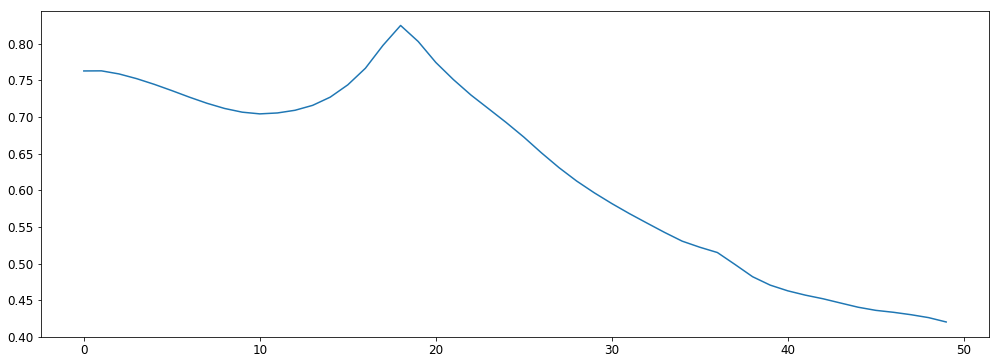

In [27]:
model = SVR(kernel = 'rbf')
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### KNN

- avg values from k nearest neighbours
- used for both classification (more) and regression
- Distance functions: Euclidean, Manhattan, Minkowski and Hamming (for categorical vars) distance
- choosing K is a challenge: Determine by Elbow graph
- Considerations
    - computationally ex
    - MUST normalise data, as high range variables can bias it

Min Test Loss :  0.8936453933864112
K value for min test loss :  14


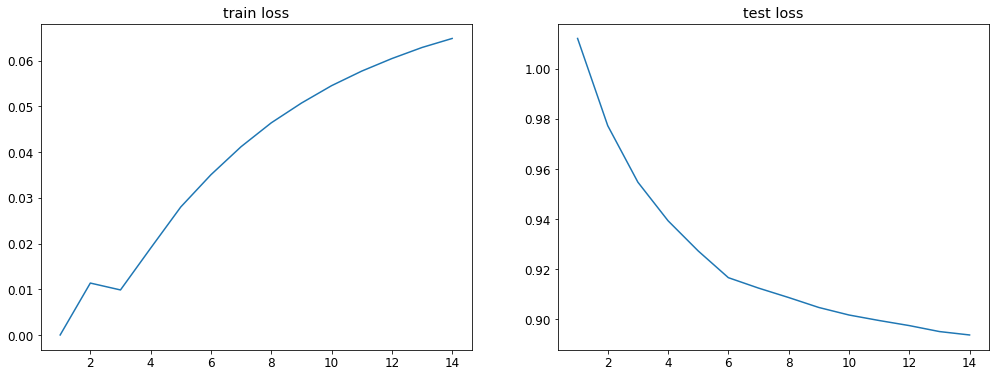

In [28]:
from sklearn import neighbors

test_loss = [] # to store rmse values for different k
train_loss = [] 

K_RNG = range(1,15)
for K in K_RNG:
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    train_loss.append(mse_train)
    test_loss.append(mse_test)

print('Min Test Loss : ', min(test_loss))
print('K value for min test loss : ', K_RNG[test_loss.index(min(test_loss))])
fig, axs = plt.subplots(1,2)
axs[0].plot(K_RNG, train_loss)
axs[0].set_title('train loss')
axs[1].plot(K_RNG, test_loss)
axs[1].set_title('test loss')

- For low value of k, model overfits (very low train error and high test error)


MSE on train dataset :  0.09657279177749269
MSE on test dataset :  0.8858060642599651


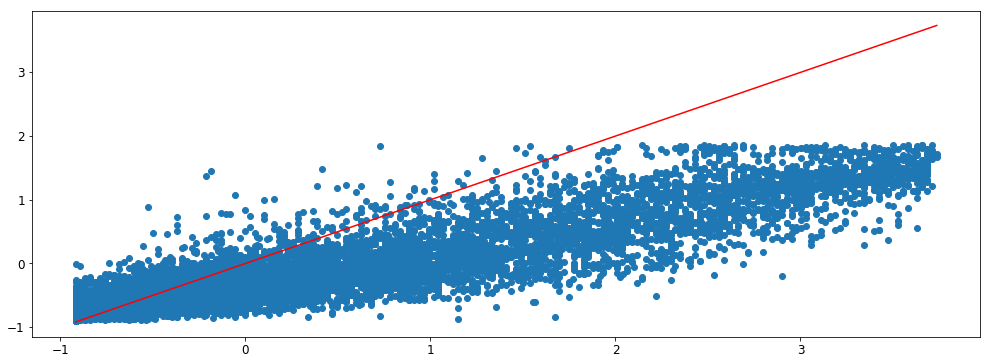

Max Lag Correlation : 0.901893 (Lag = 0)


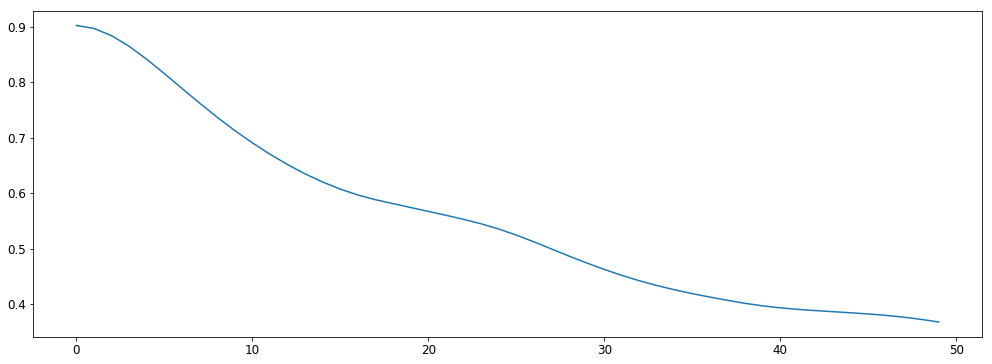

In [29]:
K = 96
model = neighbors.KNeighborsRegressor(n_neighbors = K)
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

- Even if the correlation is very strong, the loss is not beating persistence

MSE on train dataset :  0.17059059427815407
MSE on test dataset :  0.8322902521110802


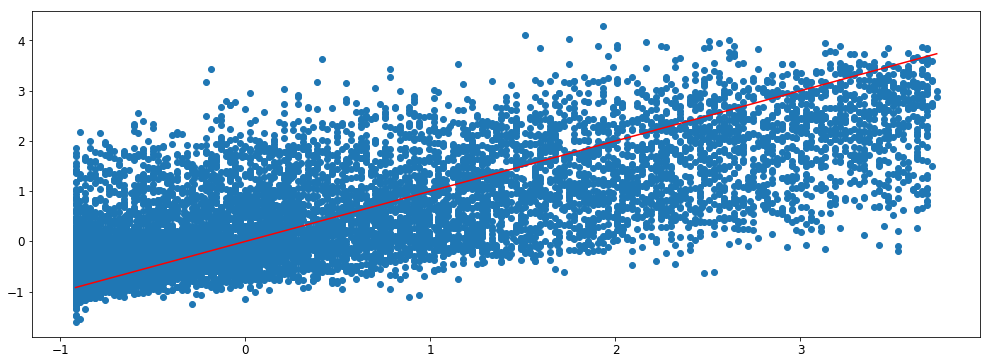

Max Lag Correlation : 0.896656 (Lag = 18)


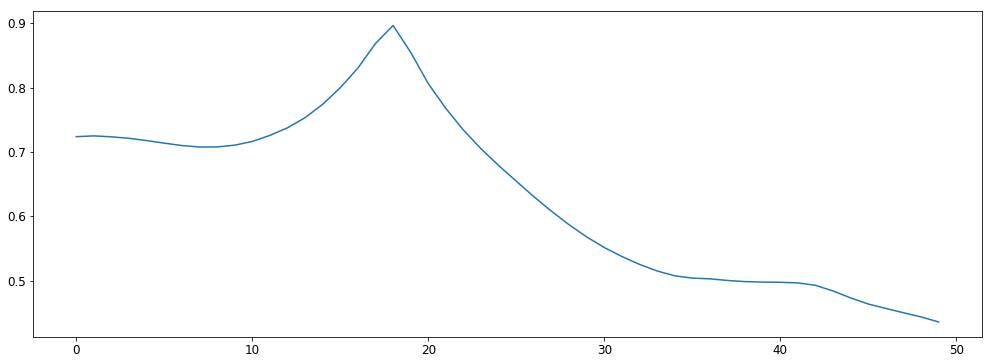

In [30]:
K = 96
model = neighbors.KNeighborsRegressor(n_neighbors = K)
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train)
b_pred_test = model.predict(A_test)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### Gradient Boosting

- good for structured problems
- for classification or regression
- ensemble algorithm that fits boosted decision trees by minimizing an error gradient
- Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.
- sci kit learn has a GB algo 
- 3rd party GB algos
    - XGBoost, LightGBM, and CatBoost
- https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on train dataset :  0.0883293018803248
MSE on test dataset :  0.8668184211788875


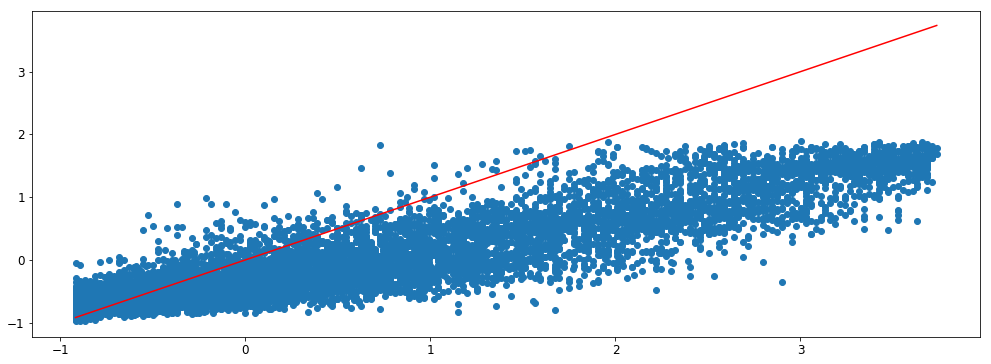

Max Lag Correlation : 0.909427 (Lag = 0)


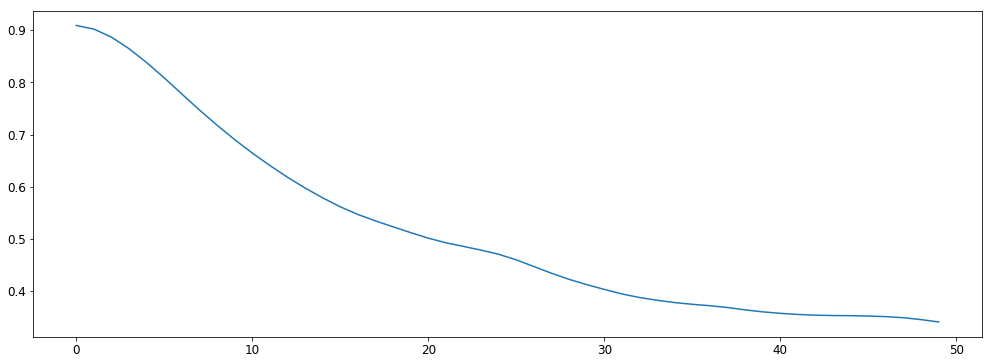

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on train dataset :  0.14493602898432453
MSE on test dataset :  0.6909850385219698


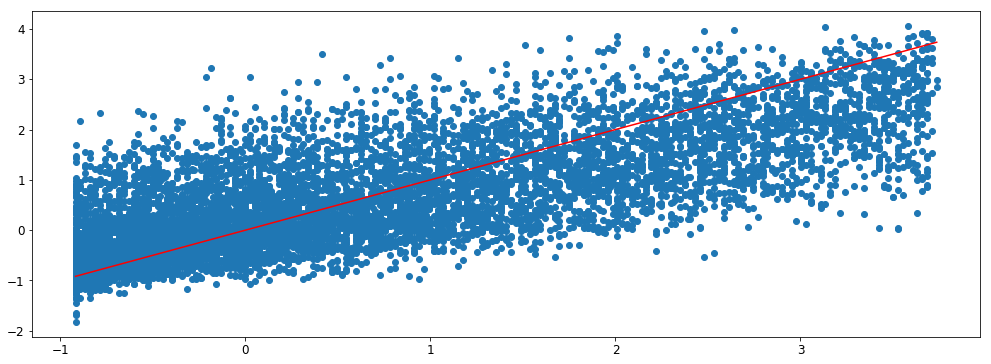

Max Lag Correlation : 0.831635 (Lag = 18)


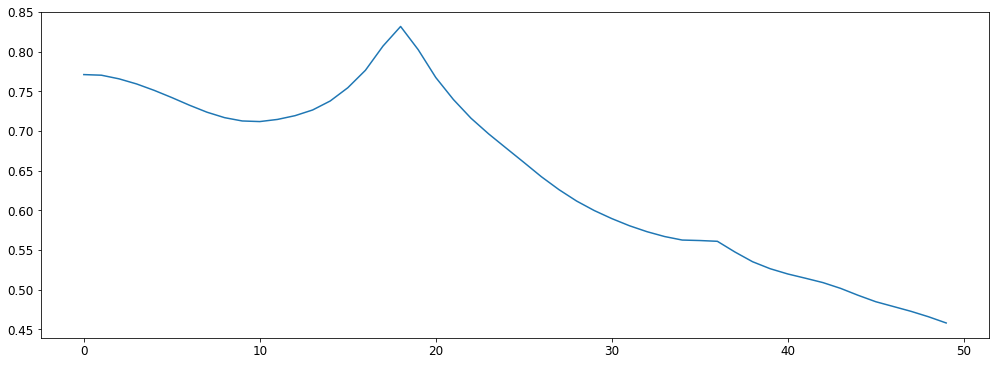

In [32]:
model = GradientBoostingRegressor()
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### XGBoost

- computational efficiency and better performance

MSE on train dataset :  0.02917001472689977
MSE on test dataset :  0.922097320922506


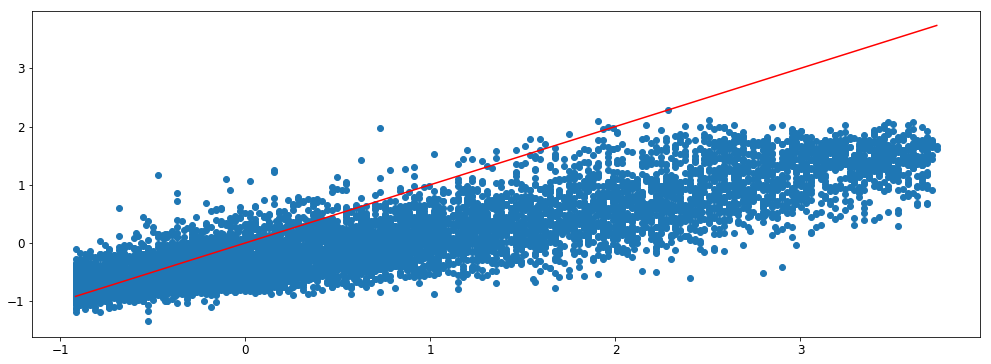

Max Lag Correlation : 0.884881 (Lag = 0)


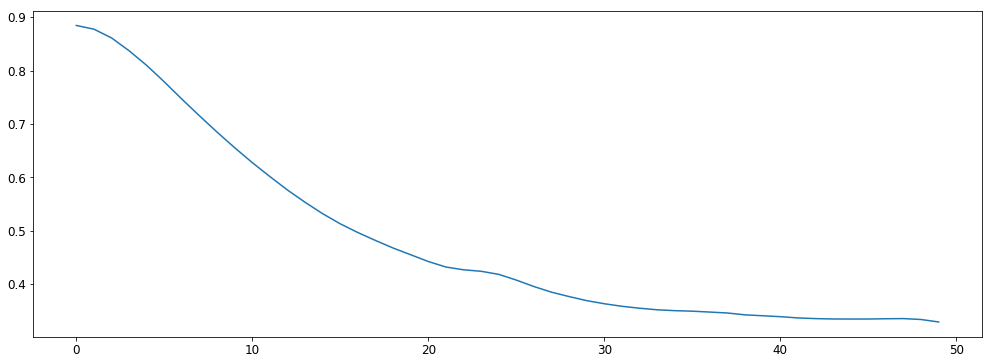

In [33]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

MSE on train dataset :  0.04587860448610415
MSE on test dataset :  0.7069238950644704


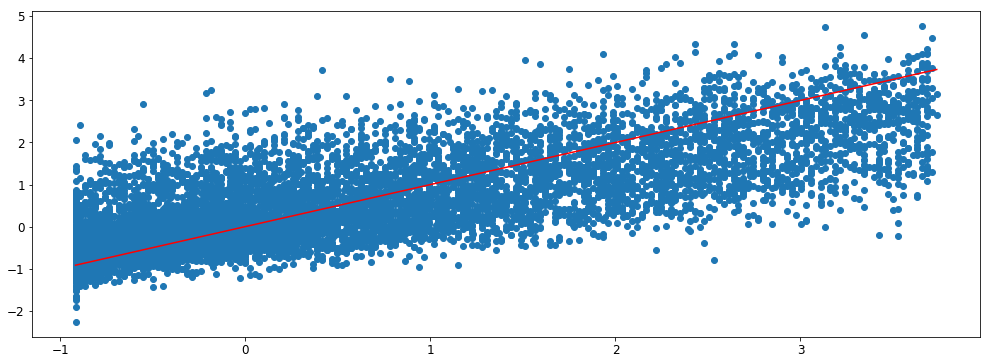

Max Lag Correlation : 0.805823 (Lag = 18)


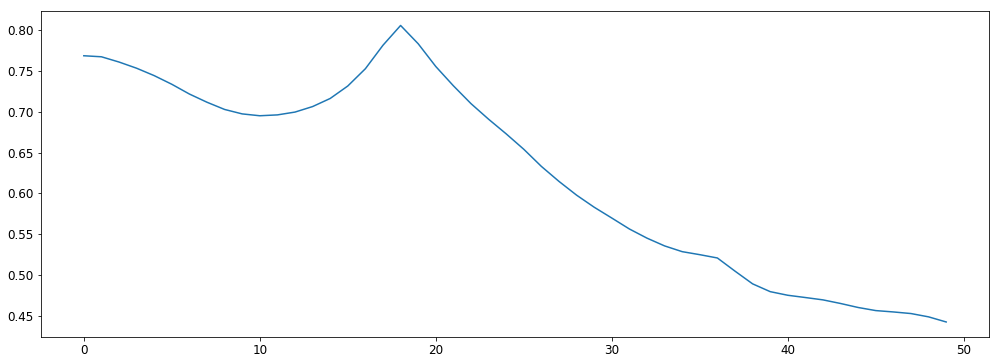

In [34]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror')
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### Light GBM

- developed by Microsoft
- very fast 

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on train dataset :  0.057424680320174136
MSE on test dataset :  0.8480000925946248


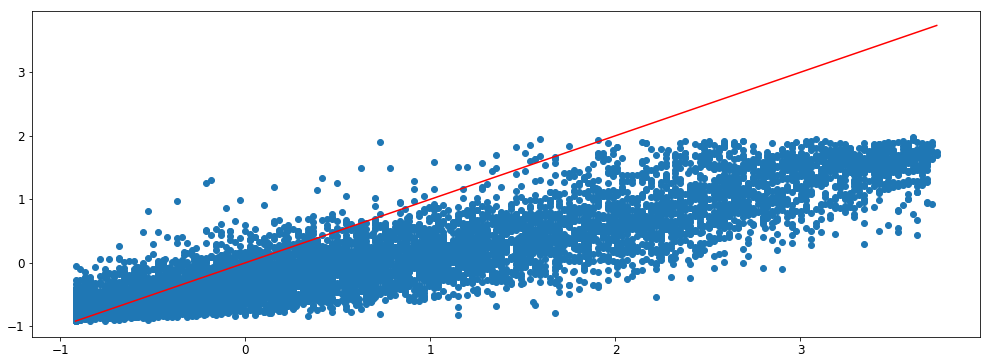

Max Lag Correlation : 0.905565 (Lag = 0)


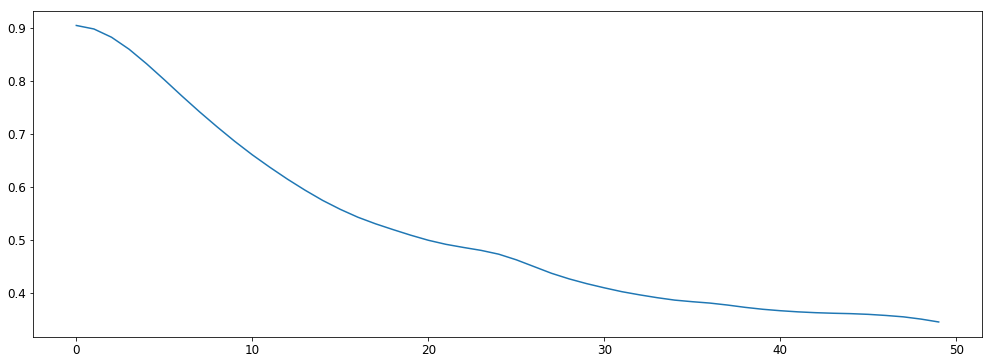

In [35]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE on train dataset :  0.09676063750061373
MSE on test dataset :  0.672088575711104


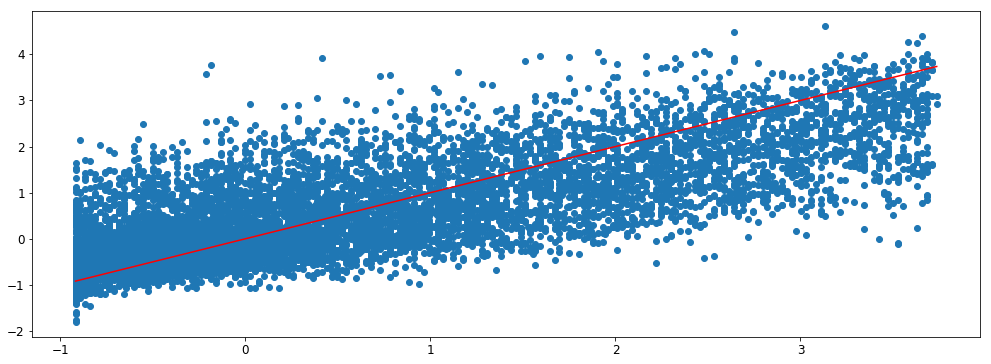

Max Lag Correlation : 0.816891 (Lag = 18)


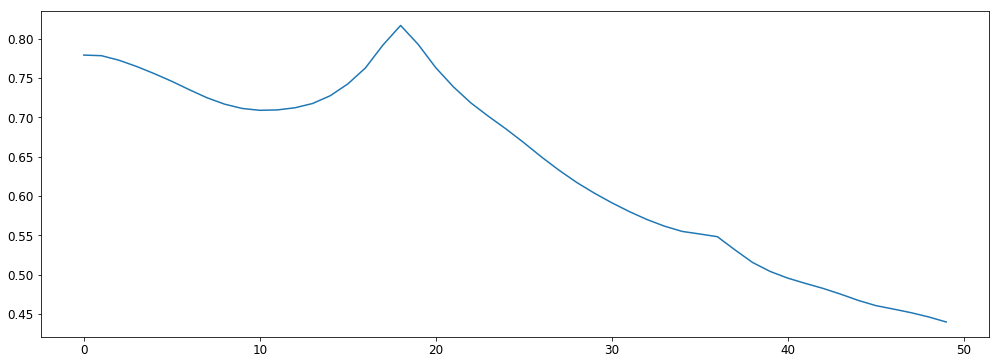

In [36]:
model = LGBMRegressor()
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### CatBoost (Category GB)

- developed by Yandex
- not only spped but support for categorical varibles


MSE on train dataset :  0.06050610478596567
MSE on test dataset :  0.908081951528034


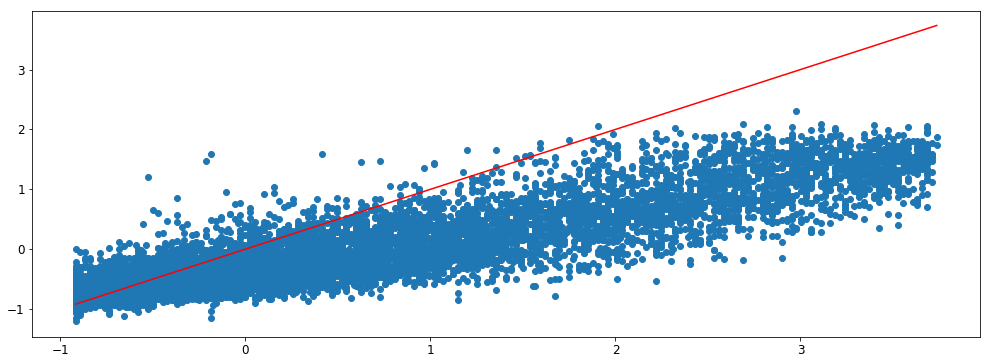

Max Lag Correlation : 0.893744 (Lag = 0)


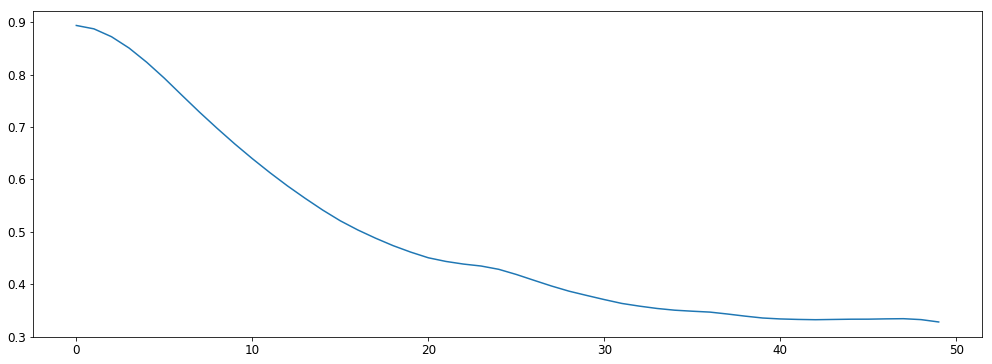

In [37]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=0, n_estimators=100)
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

MSE on train dataset :  0.09911260600991348
MSE on test dataset :  0.6982361625205026


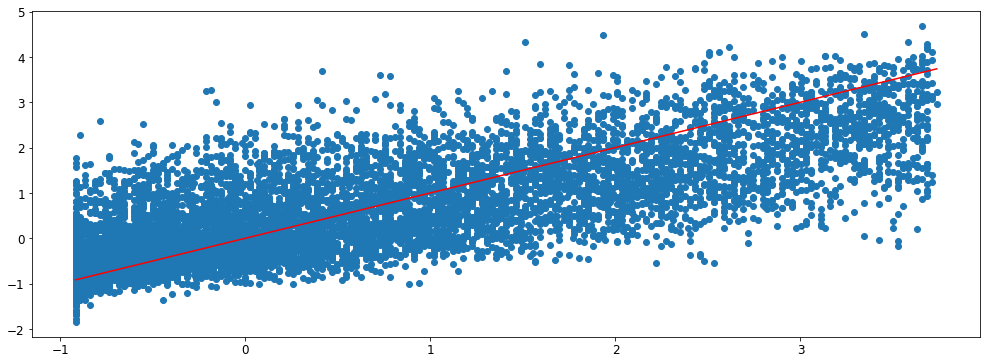

Max Lag Correlation : 0.801573 (Lag = 18)


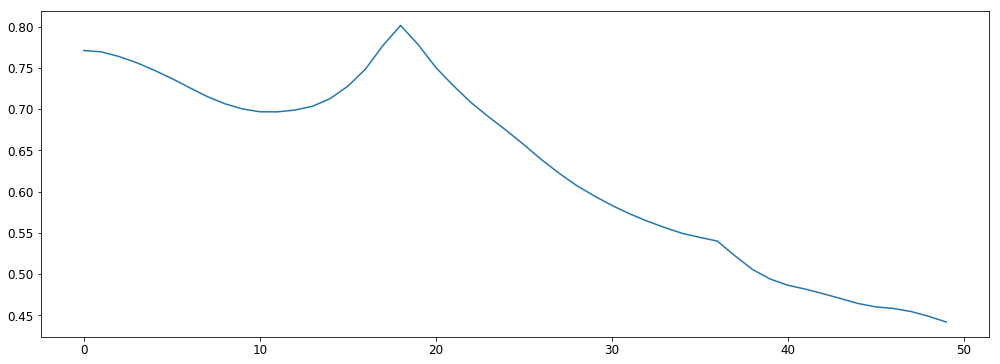

In [38]:
model = CatBoostRegressor(verbose=0, n_estimators=100)
model.fit(A_train, b_train)  

b_pred_train = model.predict(A_train).reshape(-1,1)
b_pred_test = model.predict(A_test).reshape(-1,1)

c_train, c_pred_train = b_train + b0_train, b_pred_train + b0_train
c_test, c_pred_test = b_test + b0_test, b_pred_test + b0_test

mse_train = mean_squared_error(c_train, c_pred_train)
mse_test = mean_squared_error(c_test, c_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(c_test,c_pred_test)
plot_lags(c_test,c_pred_test)

### Neural Networks

- Keras wraps TensorFlow and Theano

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

INPUT_SIZE = len(X_train[0])

def baseline_model():
    model = Sequential()
    model.add(Dense(16, input_dim=INPUT_SIZE, kernel_initializer='normal', activation='relu')) # 1 hidden layer
    model.add(Dense(1, kernel_initializer='normal')) # no actication here, bcos regression problem
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=INPUT_SIZE, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def larger_model():
    model = Sequential()
    model.add(Dense(13, input_dim=INPUT_SIZE, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10)
# results = cross_val_score(estimator, X, Y, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
model.fit(X_train, y_train)  

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on train dataset : ', mse_train)
print('MSE on test dataset : ', mse_test)

plot_preds(y_test,y_pred_test)
plot_lags(y_test,y_pred_test)

### Results for Non-differenced model

- Catboost seems to be best model beating persistence, and trains very fast
- when increased features from 20 to 40, all models perform better, although training time is longer
- NN takes longest to train

- not used
    - logistic regression (classification algo)
    - naive bayes (classification algo, usu for text classification)
    - K-means (clustering)
    - dim reduction
        - Decision Tree, Random Forest, PCA, Factor Analysis, Identify based on correlation matrix, missing value ratio
        
- Gradient Descent
    - Batch GD
        - get loss gradient for whole epoch
        - average it and adjust model parameters 
    - SGD
        - get loss grad for each iteration
        - for large datasets, BGD will take long, so this can converge faster
    - mini batch GD
        - part of epoch for training before updating model

## Other Techniques

### Advarsarial Validation

- Checks degree of similarity in terms of feature distribution in train and test sets

# Test

In [ ]:
raise Exception()